In [1]:
#make one gap with 10^6 halo
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance

import matplotlib.pyplot as plt

from tqdm import tqdm
from astropy.constants import G
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
#paths

#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
path_data = '/users/caganze/research/stellarstreams/data/rotating/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


from matplotlib.gridspec import GridSpec
%matplotlib inline
#%matplotlib notebook

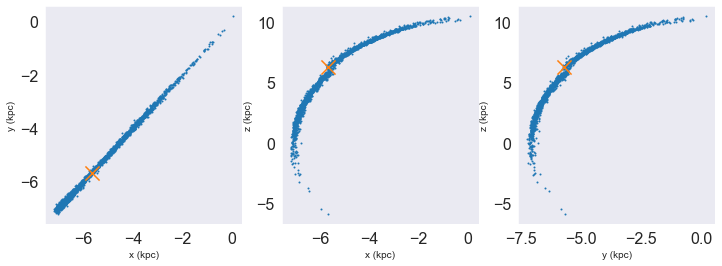

In [2]:
# generating the stream that is used in the N-body simulation
#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

df = ms.FardalStreamDF()
        
gd1_w0=gd.PhaseSpacePosition(SkyCoord(x=0*u.kpc, y=0* u.kpc,z=10*u.kpc, \
                                                v_x=150*u.km/u.s, v_y=150*u.km/u.s, v_z=0*u.km/u.s,\
                                                 frame=galcen_frame).cartesian)

#potential
MWPOT = gp.MilkyWayPotential()
H = gp.Hamiltonian(MWPOT)

#stream potential
gd1_mass = 3e4 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)


#integrate back to create a stream
gen_gd1 = ms.MockStreamGenerator(df, MWPOT, progenitor_potential=gd1_pot)
stream, nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=1500)


w0_now = gd.PhaseSpacePosition(stream.data, stream.vel)

t_int=1500

orbit = MWPOT.integrate_orbit(w0_now, dt=-1*u.Myr, n_steps=int(t_int))
old_stream = orbit[-1]

#choose impact position somewhere in the tail
impact_site= np.logical_and.reduce( [np.abs(old_stream.pos.x.value-np.mean(old_stream.pos.x.value)) >.3,
                                    np.abs(old_stream.pos.y.value-np.mean(old_stream.pos.y.value)) >.3, \
                                     np.abs(old_stream.pos.z.value-np.mean(old_stream.pos.z.value)) >.3])

#site_at_impact_w0 = gd.PhaseSpacePosition(pos=np.mean(old_stream.pos), \
#                                          vel=np.mean(old_stream.vel
site_at_impact_w0=gd.PhaseSpacePosition(pos=old_stream.pos[impact_site][0], \
                                          vel=old_stream.vel[impact_site][0])
#visualize
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(old_stream.pos.x, old_stream.pos.y, s=1)
ax[1].scatter(old_stream.pos.x, old_stream.pos.z, s=1)
ax[-1].scatter(old_stream.pos.y, old_stream.pos.z, s=1)

ax[0].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.y, s=200, marker='x')
ax[1].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.z, s=200, marker='x')
ax[-1].scatter(site_at_impact_w0.pos.y, site_at_impact_w0.pos.z, s=200, marker='x')

ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
#vxstream, vystream, vzstream not defined in this file but its just the velocity of the stream
#jk
# ---------------------------------------------------#


### These are the important definitions. The lines above are just to show how the stuff used in here are originally defined
def get_cyl_rotation(site_at_impact_w0): #borrowed from Adrian Price-Whelan's streampunch github repo
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz

    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))
    return R


def get_perturber_w0_at_impact(site_at_impact_w0, psi, v_rho, v_z, vpsi):

    # Get the rotation matrix to rotate from Galactocentric to cylindrical
    # impact coordinates at the impact site along the stream
    R = get_cyl_rotation(site_at_impact_w0)

    psi, v_rho, v_z, vpsi =  psi * u.rad, v_rho*u.km/u.s,  v_z * u.km/u.s, vpsi * u.rad/u.s

    # Define the position of the perturber at the time of impact in the
    # cylindrical impact coordinates:
    perturber_pos = astro_coord.CylindricalRepresentation(rho=0*u.kpc, 
                                                    phi=psi,
                                                    z=0*u.kpc) 

    # Define the velocity in the cylindrical impact coordinates:
    #maybe we want this to have the same vz as the stream?
    perturber_vel = astro_coord.CylindricalDifferential(
        d_rho=v_rho,
        d_phi=vpsi,
        d_z=v_z)

    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(
        astro_coord.CartesianRepresentation, astro_coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    return gd.PhaseSpacePosition(pos, vel)

In [3]:

site_at_impact_w0.represent_as(astro_coord.CylindricalRepresentation).pos

<CylindricalRepresentation (rho, phi, z) in (kpc, rad, kpc)
    (8.02333363, -2.35405061, 6.28697766)>

In [4]:
site_at_impact_w0.represent_as(astro_coord.CylindricalRepresentation).vel.d_rho.to(u.km/u.s)

<Quantity -137.80415507 km / s>

In [5]:
site_at_impact_w0.represent_as(astro_coord.CylindricalRepresentation).vel.d_z.to(u.km/u.s)

<Quantity 169.41667395 km / s>

In [6]:
#assign a new velocity to the impact position, is this right?
vel_tot= (((site_at_impact_w0.v_xyz.to(u.km/u.s)**2).sum())**0.5).value
#impact_w0= gd.PhaseSpacePosition(pos=site_at_impact_w0.pos,
#                                    vel=[0]*u.km/u.s)
impact_w0= site_at_impact_w0

#impact_w0= gd.PhaseSpacePosition(pos=site_at_impact_w0.pos,
#                                vel=[100,1, 1]*u.km/u.s)

In [7]:
#hit at random position with these paramaters
#psi, v_rho (km/s), v_z (km/s, vpsi (km/s)
frac=1e-3
vpsi= ((1*u.km/u.s)/(0.1*u.kpc)).to(u.rad/u.s, u.dimensionless_angles()).value
impact_vector=frac*(np.array([0., 1, 1, vpsi]))

In [8]:
#choose impact position parameters, is this right?

perpos=get_perturber_w0_at_impact(impact_w0, *impact_vector)
#only


[Text(0.5, 0, 'y (kpc)'), Text(0, 0.5, 'z (kpc)')]

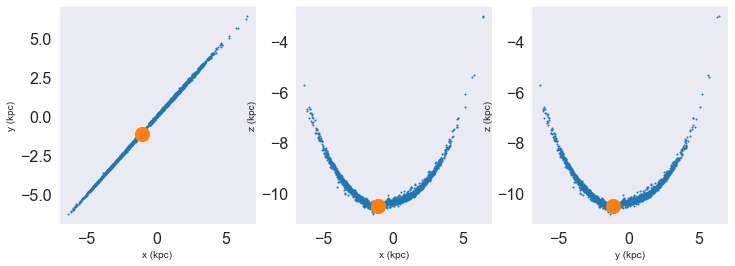

In [9]:
#integrate the orbits the stream and subhalo back by -100 Gyr and then 
stream_bfimpct= MWPOT.integrate_orbit(old_stream, dt=-1*u.Myr, n_steps=int(100))[-1]

#subhalo
subhalo_bfimpct= MWPOT.integrate_orbit(perpos, dt=-1*u.Myr, n_steps=int(100))[-1]

#visualize

fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(stream_bfimpct.pos.x, stream_bfimpct.pos.y, s=1)
ax[1].scatter(stream_bfimpct.pos.x, stream_bfimpct.pos.z, s=1)
ax[-1].scatter(stream_bfimpct.pos.y, stream_bfimpct.pos.z, s=1)

ax[0].scatter(subhalo_bfimpct.pos.x, subhalo_bfimpct.pos.y, s=200, marker='o')
ax[1].scatter(subhalo_bfimpct.pos.x, subhalo_bfimpct.pos.z, s=200, marker='o')
ax[-1].scatter(subhalo_bfimpct.pos.y, subhalo_bfimpct.pos.z, s=200, marker='o')

ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
#vxstream, vystream, vzstream not defined in th

In [10]:
print (perpos.xyz-site_at_impact_w0.xyz)
print  (perpos.v_xyz-site_at_impact_w0.v_xyz)

[0. 0. 0.] kpc
[-0.00026562  0.00115326  0.00077423] km / s


In [11]:
def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None,
                                  output_filename=None, nstars=None):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """

    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
     
    gd1_pot = gp.PlummerPotential(m=mass, b=4*u.pc, units=galactic)

    gen = ms.MockStreamGenerator(df, H,progenitor_potential=gd1_pot )

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True, n_particles=int(nstars/len(timedict['t'])), \
                   progress=True, **timedict)


def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,
                           filename='mockstream',
                            output_every=1, potential_type='plummer', nstars=None):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r*u.pc, units=galactic)
    
    #if potential_type
    if  potential_type.lower()=='hern':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r*u.pc, units=galactic)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=MWPOT )
    
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,
                                          nstars=nstars,
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename+'.h5')

In [12]:
#visualize impact 

In [13]:
#integrate forward to 200 yr
T={'t':np.linspace(0*u.Myr,3000*u.Myr, 1000 )}
#mean stream position
st_x=gd.PhaseSpacePosition(pos= np.mean(stream_bfimpct.pos).xyz,
                            vel=[np.mean(stream_bfimpct.vel).d_x.value, \
                                 np.mean(stream_bfimpct.vel).d_y.value,\
                                 np.mean(stream_bfimpct.vel).d_z.value]*u.kpc/u.Myr)

halo_x= gd.PhaseSpacePosition(pos= subhalo_bfimpct.pos,
                                vel=subhalo_bfimpct.vel)

mhalo=10**6
rhalo=1005*((mhalo/10**8)**0.5)
#rhalo=0.01

#res= run_stream_and_subhalo(mhalo, gd1_mass, rhalo, halo_x, st_x, T,
#                           filename=filename, nstars=1000,
#                            output_every=1, potential_type='hern')

In [14]:

#visualize impact  
def compute_and_plot_distance_stream_halo(filename, T):
    
    bd, st=read_stream_file(filename+'.h5')
    #st_pos=st['pos'][:,0]
    bd_pos= bd['pos'][:, :,0]
    st_pos= bd['pos'][:, :,1]
    
    fig, ax=plt.subplots(figsize=(12, 4))
    
    ax.plot(T['t'], np.nansum((st_pos-bd_pos)**2, axis=0)**0.5, linewidth=3)
    
    ax.set(xlabel='Time (Myr)', ylabel='Difference (stream-halo)')
    
    
    
    
    
def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont


def plot_stream_at_particular_step(step, filename):
    
    bd, st=read_stream_file(filename)

    
    st_pos=st['pos'][:,step]
    bd_pos= bd['pos'][:,step]
    
    
    
    #visualize
    fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
    #plot r vs z
    ax[0].scatter(st_pos[0], st_pos[1], s=1)
    ax[0].scatter(bd_pos[0], bd_pos[1], s=100, c=['r', 'b'])
    

    ax[1].scatter(st_pos[0], st_pos[2], s=1)
    ax[1].scatter(bd_pos[0], bd_pos[2], s=100, c=['r', 'b'])
    
    ax[-1].scatter(st_pos[1], st_pos[2], s=1)
    ax[-1].scatter(bd_pos[1], bd_pos[2], s=100, c=['r', 'b'])
    
    #for a in ax:
    ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
    ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
    ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
    
    plt.tight_layout()
        
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))


    return image


def visualize_impact(filename, T, tcol=1200*u.Myr,  dt= 30*u.Myr, frames=20):
    
    #chose steps
    steps= np.arange(len(T['t']))[np.logical_and(T['t']>tcol-dt, T['t']>tcol+dt)]
    skip=1
    chosen_steps=steps
    #choose steps until we reach 20 frames total
    while len(chosen_steps) > frames:
        chosen_steps=steps[::skip]
        skip +=1

    kwargs_write = {'fps':1, 'quantizer':'nq'}
    _= imageio.mimsave(path_plot+'/'+ filename+'vzonly.gif',\
                       [ plot_stream_at_particular_step(step, filename+'.h5') for step in \
                                         chosen_steps], \
                       fps=5)
    return 
    


In [15]:
#linear time
nsteps=1500
time_linear= {'t': np.arange(0, 1500)*u.Myr}
#FIRST RUN A STREAM FROM POINT 0 TO T
gen_gd1 = ms.MockStreamGenerator(df, MWPOT, progenitor_potential=gd1_pot)
stream, nbody = gen_gd1.run(st_x, gd1_mass, **time_linear, n_steps=1500, output_every=1, \
                            output_filename=path_data+filename+'.h5',    check_filesize=True, overwrite=True, progress=True)


NameError: name 'filename' is not defined

In [ ]:
#PICK A POINT IN THE STREAM ALONG AT A CERTAIN POINT
tcol=500*u.Myr
tcol_duration=50*u.Myr 

#get full stream and body
bdy, st= read_stream_file(filename+'.h5')

In [ ]:
bdy['pos']

In [ ]:
#pick the stream at collision
step= np.arange(len(time_linear['t']))[time_linear['t']== tcol][0]

stream_stars_pos_at_impact=  st['pos'][:,step]
stream_stars_vel_at_impact=  st['vel'][:,step]
stream_prog_at_impact=  bdy['pos'][:,step]

#pick the subhalo hit position at 0.3 kpc from the center
distance_stream_center=(np.nansum((stream_stars_at_impact-stream_prog_at_impact)**2, axis=0)**0.5)
impact_bool= np.logical_and(distance_stream_center <=0.3, distance_stream_center >=0.29)

In [ ]:
impact_pos=np.nanmedian([stream_stars_pos_at_impact[0][impact_bool],
            stream_stars_pos_at_impact[1][impact_bool],
            stream_stars_pos_at_impact[2][impact_bool]], axis=1)

impact_vel= np.nanmedian([stream_stars_vel_at_impact[0][impact_bool],
                          stream_stars_vel_at_impact[1][impact_bool],
                          stream_stars_vel_at_impact[-1][impact_bool]], axis=1)

#impact
impact_w0= gd.PhaseSpacePosition(pos=impac_pos*u.kpc,
                                vel= impact_vel*u.kpc/u.Myr )

In [ ]:
#idea only run stream ana gap during ~100 Myr 
#just like you can remove the subhalo, you can add it at a certain time 
#process
# - run orbits given ICS
#  run stream alone
# pick the current position
# - add subhalo at moment of interaction
# remove subhalo
#keep generating stars

In [ ]:
 visualize_impact(filename, T, tcol=1500*u.Myr,  dt= 10*u.Myr, frames=20)

In [ ]:
fig, ax=plt.subplots(ncols=3, figsize=(14, 6))
ax[0].scatter(res[0].x, res[0].y, s=.3)
ax[1].scatter(res[0].x, res[0].z, s=.3)
ax[-1].scatter(res[0].y, res[0].z, s=.3)

ax[0].scatter(res[-1][0].x, res[-1][0].y, s=100, marker='o')
ax[1].scatter(res[-1][0].x, res[-1][0].z, s=100, marker='o')
ax[-1].scatter(res[-1][0].y, res[-1][0].z, s=100, marker='o')

ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')

In [ ]:
#fig= o.plot()

In [ ]:
#no gaps ?
#c

In [ ]:
#save
final_stream_coord=SkyCoord(x=res[0].x,
                            y=res[0].y,
                            z=res[0].z, 
                            v_x=res[0].v_x,
                            v_y=res[0].v_y,
                            v_z=res[0].v_z,
                           frame=galcen_frame)

final_prog_coord=SkyCoord(x=res[-1][0].x,
                            y=res[-1][0].y,
                            z=res[-1][0].z, 
                            v_x=res[-1][0].v_x,
                            v_y=res[-1][0].v_y,
                            v_z=res[-1][0].v_z,
                           frame=galcen_frame)

final_data={'stream': final_stream_coord, 'prog': final_prog_coord}
np.save(path_data+'/{}.npy'.format(filename), final_data)

In [ ]:
final_prog_coord

In [ ]:
#visualize orbits
o=  MWPOT.integrate_orbit(gd.combine([st_x, halo_x]),**T)
fig= o.plot()

In [ ]:
radec=final_stream_coord.transform_to(astro_coord.ICRS)
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter(radec.ra, radec.dec, s=0.5)

In [ ]:
'{:.2e}'.format(1e7)